In [1]:
# adjust imports:
import matplotlib.pyplot as plt
import numpy as np
import gzip

In [2]:
#dataset reading and normalization functions:
def one_hot_encoding(label_data):
    num_labels = len(np.unique(label_data))
    encoded_labels = np.zeros((len(label_data), num_labels), dtype=int)
    
    for i, label in enumerate(label_data):
        encoded_labels[i, label] = 1
    
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1, 28 * 28)
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test

In [3]:
# read data:
X_train, y_train, X_test, y_test = read_dataset()

# split to validation and training set:
X_validation = X_train[:10000]
y_validation = y_train[:10000]
X_training = X_train[10000:]
y_training = y_train[10000:]

In [4]:
# initialize parameters: (default values)
learning_rate = 5e-4
iterations = 100
#batch_size = 1
num_features = X_training.shape[1]
num_classes = y_training.shape[1]
weights = np.random.normal(0, 1, size=(num_features, num_classes))
regularization_coef = 1e-4
biases = np.zeros(num_classes)

In [5]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# predict function:
def predict(X):
    logits = np.dot(X, weights) + biases
    return softmax(logits)

In [10]:
# functions for performance metrics and general accuracy:
def compute_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

def compute_confusion_matrix(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i]][predicted_labels[i]] += 1
    return confusion_matrix

def calculate_metrics(confusion_matrix):
    precision = []
    recall = []
    f1_score = []
    f2_score = []

    for i in range(num_classes):
        truePos = confusion_matrix[i, i]
        falsePos = np.sum(confusion_matrix[:, i]) - truePos
        falseNeg = np.sum(confusion_matrix[i, :]) - truePos

        # Precision
        precision_i = truePos / (truePos + falsePos) if truePos + falsePos != 0 else 0
        precision.append(precision_i)

        # Recall
        recall_i = truePos / (truePos + falseNeg) if truePos + falseNeg != 0 else 0
        recall.append(recall_i)

        # F1 Score
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if precision_i + recall_i != 0 else 0
        f1_score.append(f1_score_i)

        # F2 Score
        f2_score_i = 5 * (precision_i * recall_i) / (4 * precision_i + recall_i) if precision_i + recall_i != 0 else 0
        f2_score.append(f2_score_i)

    return precision, recall, f1_score, f2_score

In [7]:
def train(X, y, weights, biases, batch_size, learning_rate, regularization_coef, epochs=100):
    accuracies = []
    for epoch in range(epochs):
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            prediction = predict(X_batch)
            loss = np.sum(prediction - y_batch, axis=0)
            weights -= (np.dot(X_batch.T, prediction - y_batch) + regularization_coef * weights) * learning_rate
            biases -= learning_rate * loss

        # Evaluate on the validation set
        val_predictions = predict(X_validation)
        val_accuracy = compute_accuracy(val_predictions, y_validation)
        val_confusion_matrix = compute_confusion_matrix(val_predictions, y_validation)

        #print(f"Validation Accuracy: {val_accuracy}")
        #print("Confusion Matrix:")
        #print(val_confusion_matrix)   
        accuracies.append(val_accuracy)
    val_predictions = predict(X_test)
    val_accuracy = compute_accuracy(val_predictions, y_test)
    val_confusion_matrix = compute_confusion_matrix(val_predictions, y_test)

    print(f"Test Accuracy: {val_accuracy}")
    print("Confusion Matrix:")
    print(val_confusion_matrix)    
    precision, recall, f1_score, f2_score = calculate_metrics(val_confusion_matrix)
    for i in range(0,10):
        print("Class: ", i)
        print("Precision:", precision[i])
        print("Recall:", recall[i])
        print("F1 Score:", f1_score[i])
        print("F2 Score:", f2_score[i])
    return accuracies

Test Accuracy: 0.9098
Confusion Matrix:
[[ 955    0    2    1    0   13    5    3    1    0]
 [   0 1100    5    2    1    4    3    2   18    0]
 [   7   11  902   24    7    6   14   13   38   10]
 [   5    1   19  894    0   42    4   13   24    8]
 [   3    1    8    2  896    1    7    5    8   51]
 [  10    4    6   32    9  773   15    4   31    8]
 [  14    3   13    2   13   20  889    1    3    0]
 [   0    8   21    5   11    2    1  931    7   42]
 [   9    5   12   23    8   44   11    8  845    9]
 [   9    5    3    9   32    7    1   20   10  913]]
Class:  0
Precision: 0.9436758893280632
Recall: 0.9744897959183674
F1 Score: 0.9588353413654619
F2 Score: 0.9681670721816708
Class:  1
Precision: 0.9666080843585237
Recall: 0.9691629955947136
F1 Score: 0.9678838539375275
F2 Score: 0.968650933427263
Class:  2
Precision: 0.9101917255297679
Recall: 0.874031007751938
F1 Score: 0.8917449332674247
F2 Score: 0.8810314514553624
Class:  3
Precision: 0.8993963782696177
Recall: 0.885148

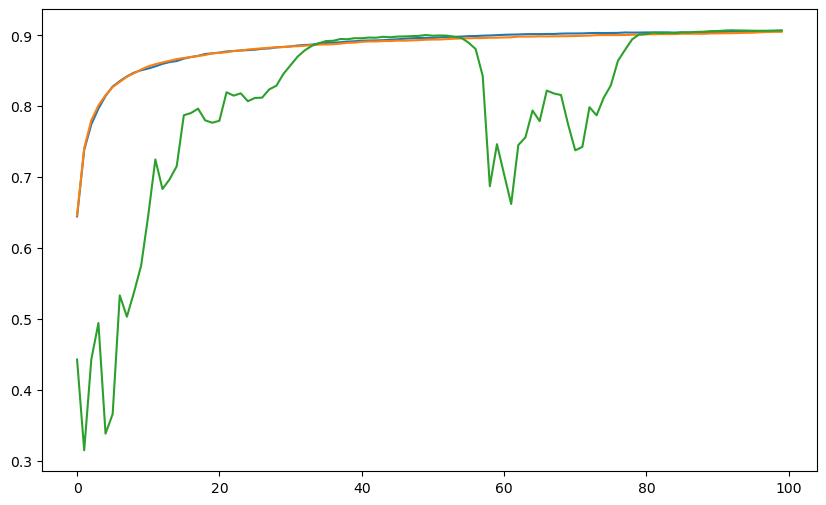

In [19]:
# initialize parameters: (default values)
learning_rate = 5e-4
iterations = 100
num_features = X_training.shape[1]
num_classes = y_training.shape[1]
weights = np.random.normal(0, 1, size=(num_features, num_classes))
regularization_coef = 1e-4
biases = np.zeros(num_classes)

batch_sizes = [1, 64, 50000]

accuracy_results = {}

for batch_size in batch_sizes:
    weights = np.random.normal(0, 1, size=(num_features, num_classes))
    biases = np.zeros(num_classes)

    accuracies = train(X_training, y_training, weights, biases, batch_size, learning_rate, regularization_coef, epochs=100)
    accuracy_results[batch_size] = accuracies

plt.figure(figsize=(10, 6))
for batch_size, accuracies in accuracy_results.items():
    epochs = range(0, 100)
    plt.plot(epochs, accuracies, label=f'Batch Size: {batch_size}')

Test Accuracy: 0.9251
Confusion Matrix:
[[ 960    0    2    3    0    5    6    3    1    0]
 [   0 1109    2    2    0    1    4    2   15    0]
 [   8    9  920   16    8    4   14   10   37    6]
 [   4    0   18  916    0   27    3   12   20   10]
 [   1    2    5    1  912    0   10    5    9   37]
 [  10    2    3   31    8  783   16    6   26    7]
 [  11    3    3    2    8   15  910    3    3    0]
 [   1    7   22    7    6    2    0  947    2   34]
 [   8    9    6   23    8   28   11   10  862    9]
 [  11    8    1    8   22    6    0   13    8  932]]
Class:  0
Precision: 0.9467455621301775
Recall: 0.9795918367346939
F1 Score: 0.9628886659979939
F2 Score: 0.9728415079043371
Class:  1
Precision: 0.9651871192341166
Recall: 0.9770925110132158
F1 Score: 0.9711033274956217
F2 Score: 0.9746879943751099
Class:  2
Precision: 0.9368635437881874
Recall: 0.8914728682170543
F1 Score: 0.9136047666335652
F2 Score: 0.9001956947162428
Class:  3
Precision: 0.9078295341922695
Recall: 0.9069

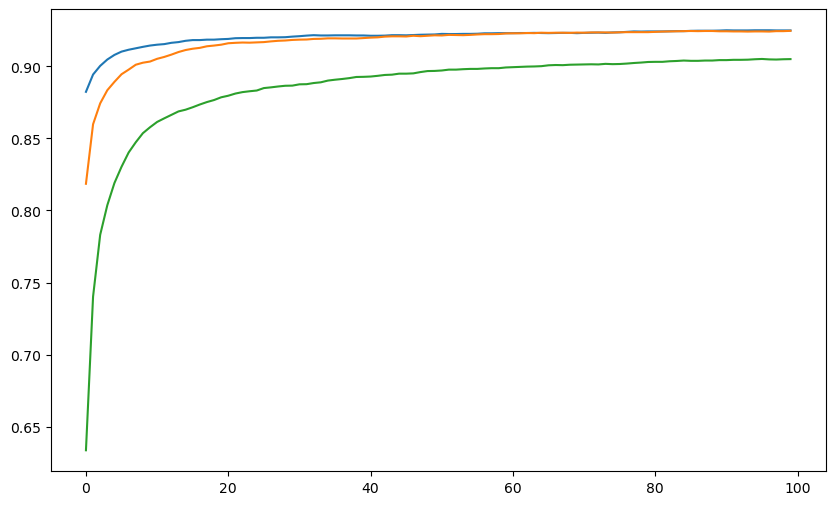

In [11]:
# initialize parameters: (default values)
learning_rate = 5e-4
iterations = 100
batch_size = 200
num_features = X_training.shape[1]
num_classes = y_training.shape[1]
weights = np.random.normal(0, 1, size=(num_features, num_classes))
regularization_coef = 1e-4
biases = np.zeros(num_classes)

# for discussing different weight initialization methods:
for i in range(0,3):
    # Re-initialize weights and biases for each batch size
    if ( i == 0):
        weights = np.zeros((num_features, num_classes))
    elif ( i == 1 ):
        weights = np.random.uniform(low=0, high=1, size=(num_features, num_classes))
    else:
        weights = np.random.normal(0, 1, size=(num_features, num_classes))
    biases = np.zeros(num_classes)

    accuracies = train(X_training, y_training, weights, biases, 200, learning_rate, regularization_coef, epochs=100)
    accuracy_results[i] = accuracies

weight_initialization = ['zero', 'uniform', 'normal']
plt.figure(figsize=(10, 6))
for index, (label, accuracies) in enumerate(accuracy_results.items()):
    epochs = range(0, 100)
    plt.plot(epochs, accuracies, label=f'Weight initialization: {weight_initialization[index]}')

Test Accuracy: 0.8806
Confusion Matrix:
[[ 963    0    1    2    3    8    1    2    0    0]
 [   0 1124    3    1    0    2    4    1    0    0]
 [  10   36  898   35   10    5   13    5   11    9]
 [   5    5   19  909    2   48    3    8    1   10]
 [   1    7    5    2  903    1    9    1    3   50]
 [   9    7    3   24   14  805   11    3    9    7]
 [  13    6    7    2    7   28  891    2    1    1]
 [   2   16   20   12   16    6    0  867    2   87]
 [  19   71   22  125   29  107   13    4  508   76]
 [   9   10    1   10   21   12    0    8    0  938]]
Class:  0
Precision: 0.9340446168768186
Recall: 0.9826530612244898
F1 Score: 0.95773247140726
F2 Score: 0.9725308018582105
Class:  1
Precision: 0.8767550702028081
Recall: 0.9903083700440528
F1 Score: 0.9300786098469176
F2 Score: 0.9653040192373755
Class:  2
Precision: 0.9172625127681308
Recall: 0.8701550387596899
F1 Score: 0.8930880159124812
F2 Score: 0.8791854317603289
Class:  3
Precision: 0.8101604278074866
Recall: 0.9
F1 S

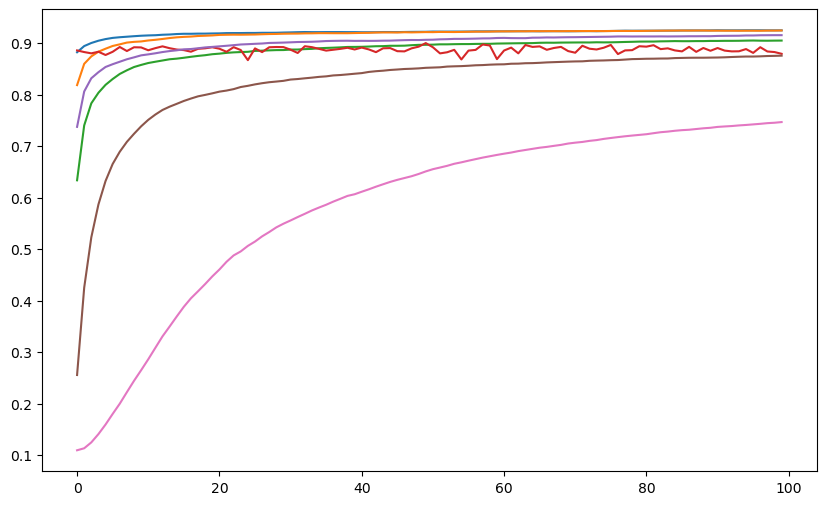

In [14]:
# initialize parameters: (default values)
learning_rate = 5e-4
iterations = 100
batch_size = 64
num_features = X_training.shape[1]
num_classes = y_training.shape[1]
weights = np.random.normal(0, 1, size=(num_features, num_classes))
regularization_coef = 1e-4
biases = np.zeros(num_classes)

learning_rates = [0.1, 1e-3, 1e-4, 1e-5]

for learning_rate in learning_rates:
    # Re-initialize weights and biases for each batch size
    weights = np.random.normal(0, 1, size=(num_features, num_classes))
    biases = np.zeros(num_classes)

    accuracies = train(X_training, y_training, weights, biases, 200, learning_rate, regularization_coef, epochs=100)
    accuracy_results[learning_rate] = accuracies
plt.figure(figsize=(10, 6))
for index, (label, accuracies) in enumerate(accuracy_results.items()):
    epochs = range(0, 100)
    plt.plot(epochs, accuracies, label=f'Learning Rate: {learning_rate}')

Test Accuracy: 0.9108
Confusion Matrix:
[[ 951    0    3    5    0    9    8    1    2    1]
 [   0 1103    5    1    0    4    3    3   16    0]
 [   8   13  913   20    8    8   14   10   30    8]
 [   4    3   19  902    1   33    2   13   22   11]
 [   1    2    7    4  888    3   13    4   14   46]
 [  11    3    7   40   12  765   14    6   29    5]
 [  11    3    9    2   12   17  898    1    5    0]
 [   1    9   23    7    7    2    0  936    1   42]
 [  10    4    8   26   11   38    9   10  844   14]
 [   9    7    3   12   32    9    0   22    7  908]]
Class:  0
Precision: 0.9453280318091452
Recall: 0.9704081632653061
F1 Score: 0.9577039274924473
F2 Score: 0.9652862362971986
Class:  1
Precision: 0.9616390584132519
Recall: 0.9718061674008811
F1 Score: 0.9666958808063102
F2 Score: 0.9697555829083874
Class:  2
Precision: 0.9157472417251755
Recall: 0.8846899224806202
F1 Score: 0.8999507146377527
F2 Score: 0.8907317073170733
Class:  3
Precision: 0.8851815505397449
Recall: 0.8930

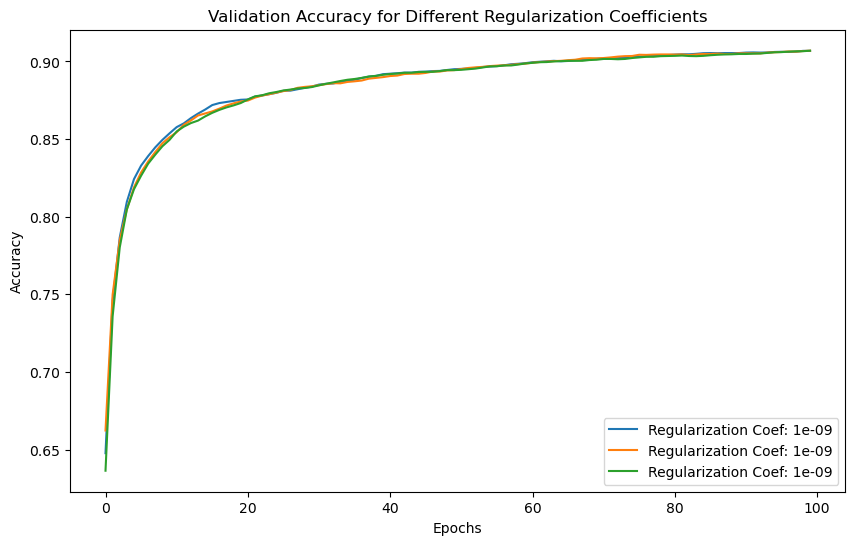

In [18]:
learning_rate = 5e-4
iterations = 100
batch_size = 64
num_features = X_training.shape[1]
num_classes = y_training.shape[1]
weights = np.random.normal(0, 1, size=(num_features, num_classes))
regularization_coef = 1e-4
biases = np.zeros(num_classes)
regularization_coefficients = [0.01, 1e-4, 1e-9]
for regularization_coefficient in regularization_coefficients:
    # Re-initialize weights and biases for each batch size
    weights = np.random.normal(0, 1, size=(num_features, num_classes))
    biases = np.zeros(num_classes)

    accuracies = train(X_training, y_training, weights, biases, 200, learning_rate, regularization_coefficient, epochs=100)
    accuracy_results[regularization_coefficient] = accuracies
plt.figure(figsize=(10, 6))
for index, (label, accuracies) in enumerate(accuracy_results.items()):
    epochs = range(0, 100)
    plt.plot(epochs, accuracies, label=f'Regularization Coef: {regularization_coefficient}')

plt.title('Validation Accuracy for Different Regularization Coefficients')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# First it trains the model with default parameters,
# then it trains the model with the parameters i believe best performed
# for each case, it shows performance metrics for the test set and the confusion matrix
# initialize parameters: (default values)
learning_rate = 5e-4
iterations = 100
num_features = X_training.shape[1]
num_classes = y_training.shape[1]
weights = np.random.normal(0, 1, size=(num_features, num_classes))
regularization_coef = 1e-4
biases = np.zeros(num_classes)
accuracy_results = {}
for i in range(0,2):
    # Re-initialize weights and biases for each batch size
    biases = np.zeros(num_classes)

    if (i == 0):
        weights = np.random.normal(0, 1, size=(num_features, num_classes))
        accuracies = train(X_training, y_training, weights, biases, 200, learning_rate, regularization_coef, epochs=100)
    else:
        weights = np.zeros((num_features, num_classes))
        accuracies = train(X_training, y_training, weights, biases, 64, 0.001, 0.01, epochs=100)


Test Accuracy: 0.9095
Confusion Matrix:
[[ 948    0    4    5    2    8    8    2    0    3]
 [   0 1100    2    3    1    1    4    1   23    0]
 [   8    9  908   17    9    7   12   15   39    8]
 [   4    0   18  900    1   32    4   11   28   12]
 [   2    0    9    5  903    2   11    2   10   38]
 [  10    4    4   38   12  761   16    5   32   10]
 [  10    3    7    1   17   20  896    1    3    0]
 [   2    5   18   14   10    1    0  929    5   44]
 [   6    6   11   22   14   29   17    7  849   13]
 [   8    6    0    7   41   10    0   20   16  901]]
Class:  0
Precision: 0.9498997995991983
Recall: 0.9673469387755103
F1 Score: 0.9585439838220425
F2 Score: 0.9638064253761692
Class:  1
Precision: 0.970873786407767
Recall: 0.9691629955947136
F1 Score: 0.9700176366843034
F2 Score: 0.9695046712497798
Class:  2
Precision: 0.9255861365953109
Recall: 0.8798449612403101
F1 Score: 0.9021361152508693
F2 Score: 0.888627911528675
Class:  3
Precision: 0.8893280632411067
Recall: 0.891089

Test Accuracy: 0.9227
Confusion Matrix:
[[ 960    0    1    3    0    6    7    2    1    0]
 [   0 1111    2    2    0    1    4    2   13    0]
 [   9   10  916   16    7    7   15    9   34    9]
 [   5    1   16  910    0   31    4   12   18   13]
 [   1    3    4    1  904    0   11    4    7   47]
 [  10    2    1   29    8  789   15    5   26    7]
 [  11    3    4    2    8   16  908    3    3    0]
 [   1    9   20    7    7    2    0  940    2   40]
 [   8    9    6   24    8   34   12    9  852   12]
 [  11    8    1    8   19    5    0   13    7  937]]
Class:  0
Precision: 0.9448818897637795
Recall: 0.9795918367346939
F1 Score: 0.9619238476953907
F2 Score: 0.972447325769854
Class:  1
Precision: 0.9610726643598616
Recall: 0.9788546255506608
F1 Score: 0.9698821475338281
F2 Score: 0.975245786516854
Class:  2
Precision: 0.9433573635427395
Recall: 0.8875968992248062
F1 Score: 0.9146280579131303
F2 Score: 0.8982153363404589
Class:  3
Precision: 0.908183632734531
Recall: 0.9009900

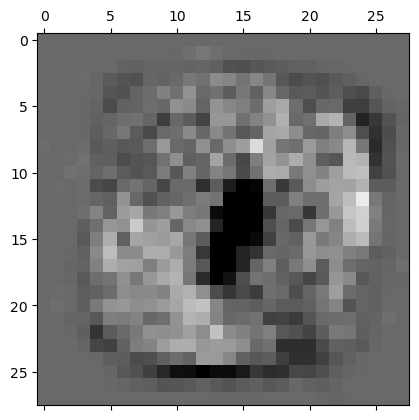

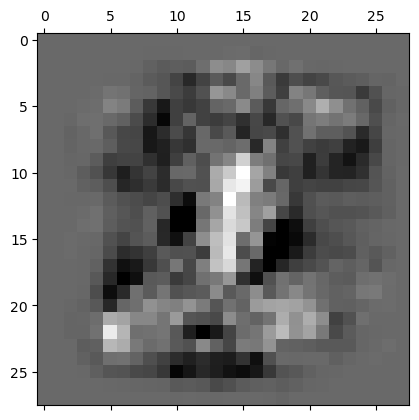

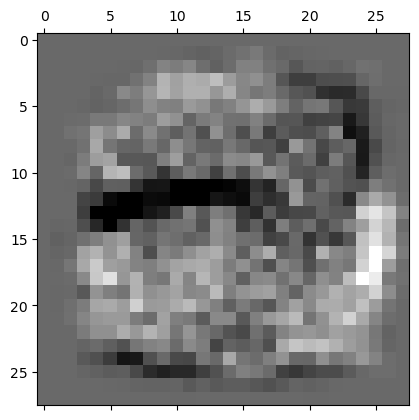

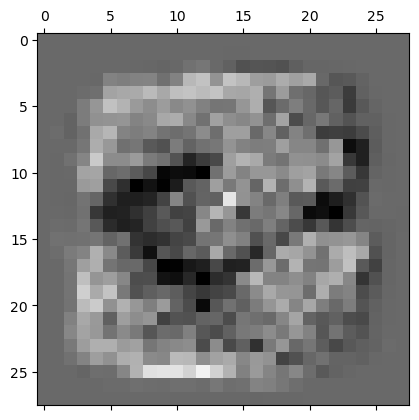

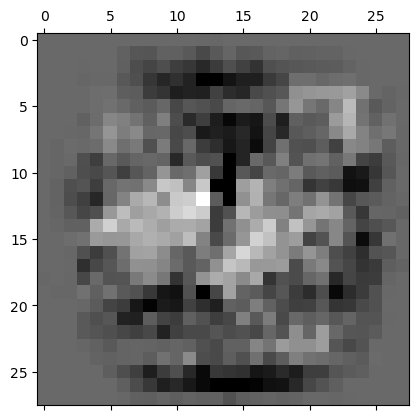

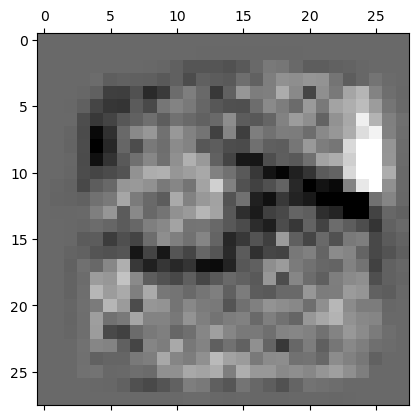

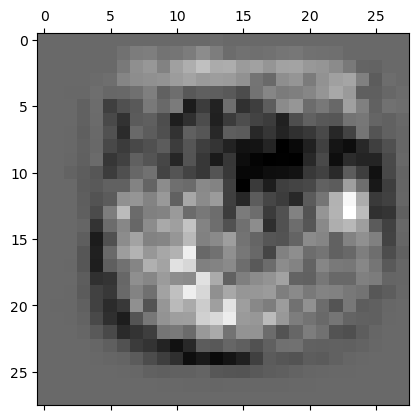

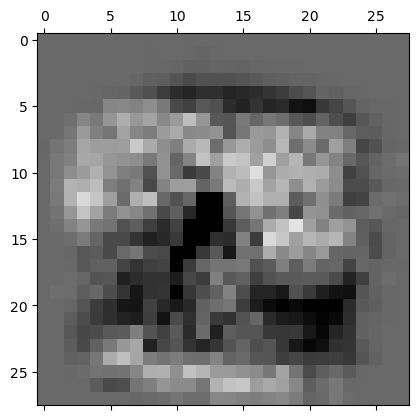

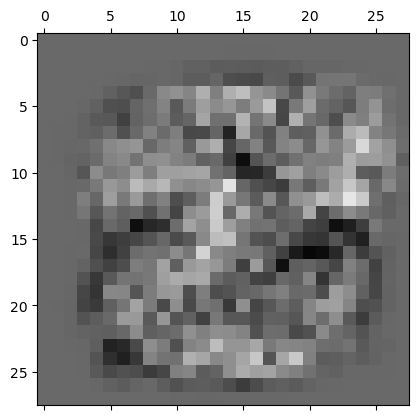

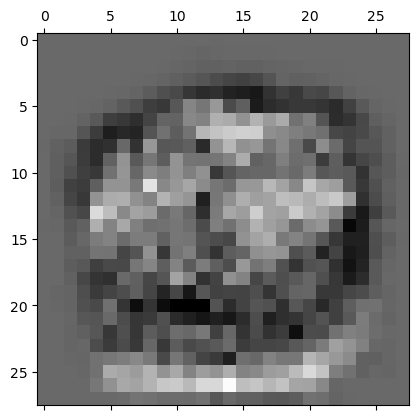

In [16]:
# For question 2.4:
weights = np.zeros((num_features, num_classes))
accuracies = train(X_training, y_training, weights, biases, 64, 0.001, 0.01, epochs=100)
for weight in weights.T:
    plt.matshow(weight.reshape(28, 28), cmap=plt.cm.gray, vmin=0.5*weights.min(), vmax=0.5*weights.max())
plt.show()